In [ ]:
# Initial setup
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

df_full = pd.read_json('yelp_academic_dataset_business.json', lines = True)
tip = pd.read_json('yelp_academic_dataset_tip.json', lines = True)

## 1. Data Preprocessing
In this section, we will transform the Yelp dataset and produce the format required for data mining and modeling through the following steps:

- Filter to U.S. restaurants that were opened in 2016
- Flatten attributes and categories
- Transform categorical variables into dummy variables
- Handling missing values

In [205]:
# Filter to U.S. restaurants that were opened in 2016
# 1) Filter to U.S. businesses
zip_crosswalk = pd.read_csv('zip_crosswalk.csv')
zip_crosswalk = zip_crosswalk.drop_duplicates(subset = ['ZIP', 'STATE'], keep = False)[['ZIP', 'STATE']]
# Transform digit-only postal code to int
digit_only = df_full['postal_code'].map(lambda x: True if all(i.isdigit() for i in x) else False)
df_full = df_full[(digit_only) & (df_full['postal_code'] != '')]
df_full['postal_code_int'] = [int(x) for x in df_full['postal_code']]
# Join crosswalk by zip and state
df_us = pd.merge(df_full, zip_crosswalk[['ZIP', 'STATE']], 
              left_on = ['postal_code_int', 'state'],
              right_on = ['ZIP', 'STATE'])

# 2) Filter to restaurants
df_us = df_us[df_us['categories'].str.contains('Restaurants|Food', na = False)]
df_us.set_index('business_id')

# 3) Filter to restaurants that were opened in 2016
start = '2016-01-01'
end = '2016-12-31'
tip = tip.groupby('business_id')['date'].min().reset_index()
tip = tip[(tip['date'] >= start) & (tip['date'] <= end)]
df = pd.merge(tip, df_us, on = 'business_id', how = 'inner')

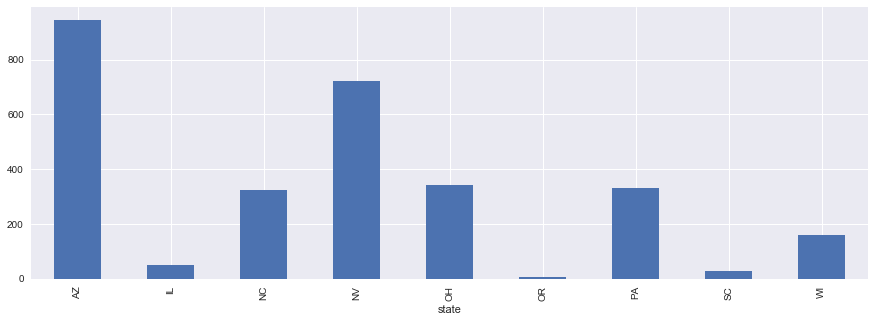

In [206]:
# Check geological distribution
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
df.groupby('state')['business_id'].count().plot(kind = 'bar')
plt.show()

In [207]:
# Drop states with few data points
state_list = ['AZ', 'NC', 'NV', 'OH', 'PA', 'WI']
print('Total data points in df:', len(df))
df = df[np.in1d(df['state'], state_list)].reset_index()
print('Total data points in df after removing a few states:', len(df))

Total data points in df: 2914
Total data points in df after removing a few states: 2827


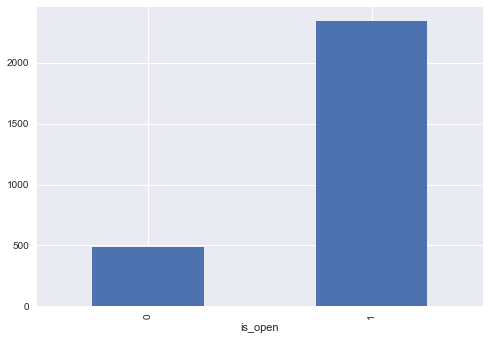

In [208]:
# Check restaurant closure
df.groupby('is_open')['business_id'].count().plot(kind = 'bar')
plt.show()

In [209]:
# Flatten attributes and categories
# 1) Categories
from collections import Counter
# Extract categories from list of lists
cat = ', '.join(df['categories'])
# Count frequency
counter = Counter(cat.split(', '))
# Append categories as dummies
for cat in list(counter.keys()):
    df[cat] = np.where(df['categories'].str.contains(cat), 1, 0)
df.drop('categories', inplace = True, axis = 1)

In [210]:
# 2) Attributes
# Unuseful attributes to be dropped
drop_list = ['AcceptsInsurance', 'AgesAllowed', 'Ambience', 'DietaryRestrictions',
             'BestNights', 'BikeParking', 'BusinessAcceptsBitcoin', 'Music', 'ByAppointmentOnly',
             'CoatCheck', 'DogsAllowed' , 'DriveThru', 'GoodForDancing', 'Smoking', 'BusinessParking', 'GoodForMeal']
# Flattening
att = df['attributes'].apply(pd.Series)
meal = att['GoodForMeal'].fillna("{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'breakfast': False, 'brunch': False}")
parking = att['BusinessParking'].fillna("{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}")
parking_list = ['garage', 'street', 'validated', 'lot', 'valet']
meal_list = ['dessert', 'latenight', 'lunch', 'dinner', 'breakfast', 'brunch']

# Define a function to flatten json lists
import ast
def flatten_json(df, col):
    for i in range(len(col)):
        json_dict = ast.literal_eval(col[i])
        for j in json_dict.keys():
            df[j] = np.where(json_dict[j], 1, 0) 
            
flatten_json(df = att, col = parking)
flatten_json(df = att, col = meal)

# Handle missing value in attributes
att['Alcohol'].fillna('none', inplace = True)
att['NoiseLevel'].fillna('average', inplace = True)
att['RestaurantsAttire'].fillna('casual', inplace = True)
att['WiFi'].fillna('no', inplace = True)
att['RestaurantsPriceRange2'].fillna(0, inplace = True)

# Transform attributes into dummy variables
att = att.drop(drop_list, axis = 1).fillna(value = False)
att = pd.get_dummies(att, drop_first = True)

# Append attributes to main dataframe
df = pd.merge(df, att, left_index = True, right_index = True)
df.drop('attributes', axis = 1, inplace = True)

## 2. External Data
In this section, we will integrate the following external data sources to the Yelp dataset:
- Zillow property price data
- Demographic data by zip code

In [211]:
# Zillow
zillow = pd.read_csv('zillow_median_price.csv', encoding='cp1252')
# Extract zipcodes
zipcodes = df['postal_code'].unique()
df['postal_code_int'] = [int(i) for i in df['postal_code']]
house_price = zillow[np.in1d(zillow['RegionName'], 
                             df['postal_code_int'])][['RegionName', '2016-01']]
house_price.columns = ['postal_code_int', 'median_sqft_price']
# Append median house price to main df
df = pd.merge(df, house_price, on = 'postal_code_int', how = 'left')
df['median_sqft_price'] = df['median_sqft_price'].fillna(df['median_sqft_price'].median())

In [212]:
# Add zip-level demographics
from uszipcode import SearchEngine
keys = ['zipcode', 'housing_units', 'land_area_in_sqmi', 'median_home_value', 'median_household_income', \
        'occupied_housing_units', 'population', 'population_density', 'annual_individual_earnings', \
        'educational_attainment_for_population_25_and_over', 'employment_status', 'families_vs_singles', \
        'households_with_kids', 'housing_occupancy', 'means_of_transportation_to_work_for_workers_16_and_over', \
        'population_by_age', 'population_by_gender', 'population_by_race', 'travel_time_to_work_in_minutes']
keep_col = ['housing_units', 'land_area_in_sqmi', 'median_home_value', 'median_household_income', \
            'occupied_housing_units', 'population', 'population_density', 'postal_code']
lst = []
for zipcode in zipcodes:
    search = SearchEngine(simple_zipcode=False) 
    item = search.by_zipcode(zipcode)
    newDict  = item.to_dict()
    lst.append([newDict.get(key) for key in keys])
keys[0] = 'postal_code'
df_demograph = pd.DataFrame(lst, columns= keys)[keep_col]
df = pd.merge(df, df_demograph, on = 'postal_code', how='inner')

## 3. Feature Engineering
In this section, we will perform feature engineering to extract the following attributes:
- Restaurant density and competition level in the neighborhood
- Whether a given restaurant belong to a local/national chain

In [213]:
len(df)

2827

In [200]:
# Restaurant density
import geopy.distance
business_id = []
density = []
avg_stars = []
avg_review_count = []
std_stars = []
std_review_count = []

# Collect a random sample from all U.S. restaurants
df_us = df_us[np.in1d(df_us['state'], state_list)]
df_us = df_us.dropna(subset = ['latitude', 'longitude'], axis = 0).reset_index()
sample_us = df_us.drop_duplicates(subset=['latitude', 'longitude', 'stars', 'review_count']).sample(n = 10000).reset_index()

In [ ]:
for i in range(len(df)):
    print('Looping over', i, '...')
    coord1 = [df.at[i, 'latitude'], df.at[i, 'longitude']]
    count = 1
    stars = 0
    review_count = 0
    for j in range(len(sample_us)):
        coord2 = [sample_us.at[j, 'latitude'], sample_us.at[j, 'longitude']]
        try:
            distance = geopy.distance.vincenty(coord1, coord2).miles
            if distance < 1:
                count = count + 1
                stars = stars + sample_us.at[j, 'stars']
                review_count = review_count + sample_us.at[j, 'review_count']
        except:
            print('Error!')
    business_id.append(df.at[i, 'business_id'])
    density.append(count)
    avg_stars.append(stars/count)
    avg_review_count.append(review_count/count)

In [218]:
biz_density = pd.DataFrame({'business_id': business_id,
                            'density' : density,
                            'avg_stars' : avg_stars,
                            'avg_review_count' : avg_review_count})
df = pd.merge(df, biz_density, on = 'business_id')

In [223]:
# Identify whether a given restaurant is a local or national chain
local_chain = df.groupby(['state', 'name'])['business_id'].count().reset_index()
local_chain.columns = ['state', 'name', 'count']
local_chain['is_local_chain'] = np.where(local_chain['count'] > 1, 1, 0)

national_chain = local_chain.groupby('name')['state'].count().reset_index()
national_chain.columns = ['name', 'count']
national_chain['is_national_chain'] = np.where(national_chain['count'] > 2, 1, 0)

df = pd.merge(df, local_chain[['name', 'state', 'is_local_chain']], on = ['state','name'])
df = pd.merge(df, national_chain[['name', 'is_national_chain']], on = ['name'])

In [228]:
list(df.columns)

['index',
 'business_id',
 'date',
 'address',
 'city',
 'hours',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'neighborhood',
 'postal_code',
 'review_count',
 'stars',
 'state',
 'postal_code_int',
 'ZIP',
 'STATE',
 'Food',
 'International Grocery',
 'Grocery',
 'Ethnic Grocery',
 'Coffee & Tea',
 'Ice Cream & Frozen Yogurt',
 'Desserts',
 'Juice Bars & Smoothies',
 'Internet Cafes',
 'Sandwiches',
 'Burgers',
 'American (Traditional)',
 'Diners',
 'Restaurants',
 'Noodles',
 'Italian',
 'Asian Fusion',
 'Comfort Food',
 'Bars',
 'Bar Crawl',
 'Nightlife',
 'Dive Bars',
 'Indian',
 'Sports Bars',
 'Beer Bar',
 'Barbeque',
 'Food Trucks',
 'Specialty Food',
 'Distilleries',
 'Tapas Bars',
 'Cocktail Bars',
 'Event Planning & Services',
 'American (New)',
 'Whiskey Bars',
 'Venues & Event Spaces',
 'Arts & Entertainment',
 'Party & Event Planning',
 'Shopping',
 'Video Game Stores',
 'Videos & Video Game Rental',
 'Books',
 'Mags',
 'Music & Video',
 'Arcades',
 'Breakfast & Brunc

In [233]:
# Data Cleaning
# pd.set_option("display.max_columns",500)
# Drop non-features
drop_col = ['index', 'business_id', 'date', 'address', 'hours', 
            'latitude','longitude','name','review_count','stars',
            'neighborhood', 'postal_code', 'postal_code_int', 'ZIP', 'STATE']
df_clean = df[(df['postal_code'] != '89158') & (df['postal_code'] != '85378')].drop(drop_col, axis = 1)

In [238]:
# Convert categorical variables to dummies
dummy_col = ['city', 'state']
df_clean = pd.get_dummies(data = df_clean, columns = dummy_col)

### 4. Modeling

In [246]:
# Resampling
df_clean.groupby('is_open')['is_open'].count()

is_open
0     508
1    2317
Name: is_open, dtype: int64

In [248]:
# Oversample restaurants that are closed
biz_open = df_clean[df_clean['is_open'] == 1]
biz_closed = df_clean[df_clean['is_open'] == 0]
biz_closed_over = biz_closed.sample(len(biz_open), replace = True)
df_over = pd.concat([biz_open, biz_closed_over])

#### 4.1 Baseline: logistic regression with regularization

In [251]:
# Baseline: logitstic regression with regularization + grid search
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

X = df_over.drop('is_open', axis = 1)
y = df_over['is_open']

kfolds = KFold(X.shape[0], n_folds = 5, shuffle = True)
steps = [('scaler', RobustScaler()),
         ('lr', LogisticRegression())]
pipeline = Pipeline(steps)

parameters_scaler = dict(lr__C = [10**i for i in range(-3, 3)],
                  lr__penalty = ['l1', 'l2'])

lr_grid_search_scaler = GridSearchCV(pipeline, param_grid = parameters_scaler, cv = kfolds, scoring = 'roc_auc')
lr_grid_search_scaler.fit(X, y)

/Users/laiyipeng/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/laiyipeng/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=sklearn.cross_validation.KFold(n=4634, n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100], 'lr__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [255]:
print('AUC score for the baseline model (logistic regression with regularization):' , 
     lr_grid_search_scaler.best_score_)

AUC score for the baseline model (logistic regression with regularization): 0.8055285533341284


#### 4.2 XGBoost (Default)

In [256]:
from xgboost import XGBClassifier
steps = [('scaler', RobustScaler()),
         ('xgb', XGBClassifier())]
pipeline = Pipeline(steps)

parameters_scaler = dict(xgb__n_estimators = [100],
                         xgb__learning_rate = [0.1])

xgb_grid_search_scaler = GridSearchCV(pipeline, param_grid = parameters_scaler, cv = kfolds, scoring = 'roc_auc')
xgb_grid_search_scaler.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=4634, n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'xgb__n_estimators': [100], 'xgb__learning_rate': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [260]:
print('AUC score for the XGBoost model (default):' , xgb_grid_search_scaler.best_score_)

AUC score for the XGBoost model (default): 0.8308215329322491


In [ ]:
steps = [('scaler', RobustScaler()),
         ('xgb', XGBClassifier())]
pipeline = Pipeline(steps)

parameters_scaler = dict(xgb__n_estimators = [50, 100, 150, 200],
                         xgb__learning_rate = [0.01, 0.1, 0.2],
                         xgb__max_depth = [3, 5, 10])

xgb_grid_search_scaler_x = GridSearchCV(pipeline, param_grid = parameters_scaler, 
                                        cv = kfolds, scoring = 'roc_auc')
xgb_grid_search_scaler_x.fit(X, y)